In [59]:
import numpy as np
import random

from scipy import sparse
from scipy.spatial import distance

from matplotlib import pyplot as plt
%matplotlib inline



In [29]:
data = np.loadtxt('data/u.data')

def load():
    # user id and item id
    ij = data[:, :2]
    ij -= 1 # original data is in 1-based system
    # rating
    values = data[:, 2]
    #reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    reviews = sparse.csc_matrix(data[:,:3]).astype(float)
    return reviews.toarray()

In [30]:
reviews = load()

In [32]:
# U - row index, M - column index where condition (reviews) is true
# Also means, return indices of row+column index where review is not empty
U, M = np.where(reviews)

In [52]:
# // - Floor Division , create a sample between 0 to 299276 with shape 29927
test_idxs = np.array(random.sample(range(len(U)), len(U)//10))
# Set training data values to be zero
train = reviews.copy()
train[U[test_idxs], M[test_idxs]] = 0
# Set test data values to be with values
test = np.zeros_like(reviews)
test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs],M[test_idxs]]

In [55]:
class NormalizePositive(object):
    # axis = 0 is columns
    def __init__(self, axis=0):
        self.axis = axis
        
    def fit(self, features, y=None):
       if self.axis == 1:
        features = features.T
        
       # count features that are greater than zero in axis 0:
       binary = (features > 0)
       count0 = binary.sum(axis=0) 
       # to avoid division by zero, set zero counts to one:
       count0[count0 == 0] = 1
       # computing the mean is easy:
       self.mean = features.sum(axis=0)/count0
       # only consider differences where binary is True:
       diff = (features - self.mean) * binary
       diff **= 2
       # regularize the estimate of std by adding 0.1
       self.std = np.sqrt(0.1 + diff.sum(axis=0)/count0)
       return self

    def transform(self, features):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary
        if self.axis == 1:
            features = features.T
        return features
    
    #un-normalize the data to view 
    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()
        if self.axis == 1:
            features = features.T
        features *= self.std
        features += self.mean
        if self.axis == 1:
            features = features.T
        return features
    
    def fit_transform(self, features):
        return self.fit(features).transform(features)

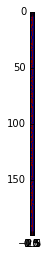

In [58]:
norm = NormalizePositive(axis=1)
binary = (train > 0)
train = norm.fit_transform(train)
plt.imshow(binary[:200, :200], interpolation='nearest')

In [ ]:
# compute all pair-wise distances:
dists = distance.pdist(binary, 'correlation')
# Convert to square form, so that dists[i,j]
# is distance between binary[i] and binary[j]:
dists = distance.squareform(dists)